In [1]:
import os
import h5py 
import numpy as np 
from scipy.signal import medfilt
# -- astropy -- 
import astropy.units as u
from astropy.table import Table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

## Read mock BGS exposures from Jeremy
The file does not currently contain any info on the sun (altitude, separation). However, we can get thise using `MJD`. 

In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, get_sun, AltAz

def exps_wSun(): 
    fexp = ''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.hdf5'])
    if os.path.isfile(fexp): 
        # read it from file
        f = h5py.File(fexp, 'r')
        exp_data = {} 
        for k in f.keys(): 
            exp_data[k] = f[k].value
    else: 
        exps = aTable.read(''.join([UT.dat_dir(), 'survey_exposures.fits']))
       
        kpno = EarthLocation.of_site('kitt peak')

        sun_alts, sun_seps = [], []
        for i in range(len(exps)): 
            mjd = exps['MJD'][i,0]
            utc_time = Time(mjd, format='mjd')
            kpno_altaz = AltAz(obstime=utc_time, location=kpno)

            # coordinate of object
            coord = SkyCoord(ra=exps['RA'][i] * u.deg, dec=exps['DEC'][i] * u.deg)
            coord_altaz = coord.transform_to(kpno_altaz)

            sun = get_sun(utc_time)
            sun_altaz = sun.transform_to(kpno_altaz) 
            sun_alts.append(sun_altaz.alt.deg) # sun altitude
            sun_seps.append(sun.separation(coord).deg) # sun separation
            #print('RA=%f, DEC=%f' % (exps['RA'][i], exps['DEC'][i]))
            #print(utc_time.datetime)
            #print('sun alt=%f, sep=%f' % (sun_altaz.alt.deg, sun.separation(coord).deg))
        exp_data = {} 
        for n in exps.colnames: 
            if len(exps[n].shape) == 1: 
                exp_data[n] = exps[n]
            else: 
                exp_data[n] = exps[:,0]
        exp_data['SUNALT'] = np.array(sun_alts)
        exp_data['SUNSEP'] = np.array(sun_seps)
        
        f = h5py.File(fexp, 'w')
        for k in exp_data.keys(): 
            f.create_dataset(k, data=exp_data[k])
        f.close()
    return exp_data

In [4]:
exps = exps_wSun()

In [5]:
nexps = len(exps['RA'])
print('%i exposures' % nexps)

4766 exposures


(0.0, 3.0)

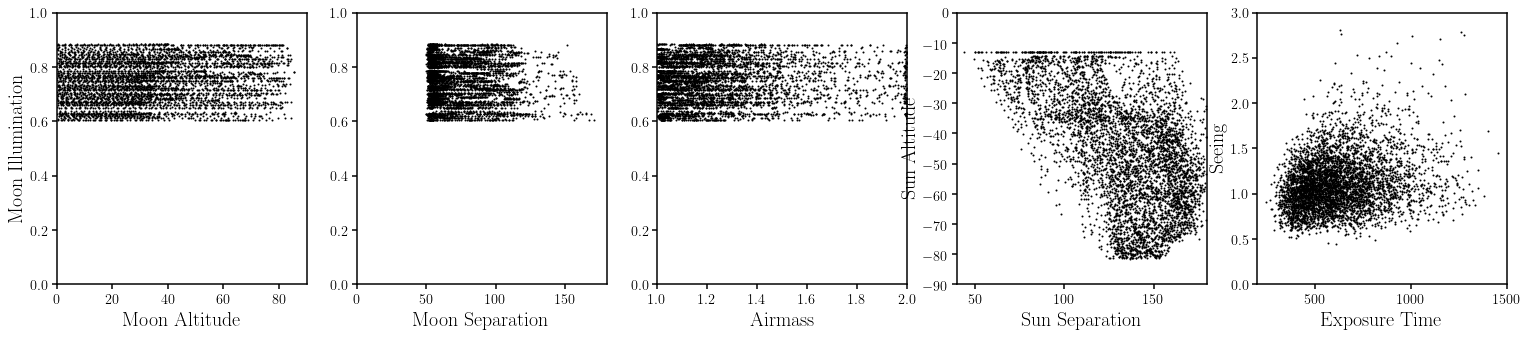

In [6]:
fig = plt.figure(figsize=(26,5))
sub = fig.add_subplot(151)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(152)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(153)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(154)
sub.scatter(exps['SUNSEP'], exps['SUNALT'], c='k', s=1)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
sub = fig.add_subplot(155)
sub.scatter(exps['EXPTIME'], exps['SEEING'], c='k', s=1)
sub.set_xlabel('Exposure Time', fontsize=20)
sub.set_xlim([200., 1500.])
sub.set_ylabel('Seeing', fontsize=20)
sub.set_ylim([0., 3.])

In [7]:
specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [8]:
cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1

def KS_sky(airmass, moonill, moonalt, moonsep): 
    # original KS sky
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr_def
    specsim_sky.moon.KS_CM0 = cm0_def
    specsim_sky.moon.KS_CM1 = cm1_def
    return specsim_sky.surface_brightness

In [9]:
import pandas as pd
from scipy.interpolate import interp1d

f = ''.join([UT.code_dir(), 'dat/sky/MoonResults.csv'])

coeffs = pd.DataFrame.from_csv(f)
coeffs.columns = [
    'wl', 'model', 'data_var', 'unexplained_var',' X2', 'rX2',
    'c0', 'c_am', 'tau', 'tau2', 'c_zodi', 'c_isl', 'sol', 'I',
    't0', 't1', 't2', 't3', 't4', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6',
    'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
    'c2', 'c3', 'c4', 'c5', 'c6']
# keep moon models
twi_coeffs = coeffs[coeffs['model'] == 'twilight']
coeffs = coeffs[coeffs['model'] == 'moon']
# order based on wavelengths for convenience
wave_sort = np.argsort(np.array(coeffs['wl']))

for k in coeffs.keys():
    coeffs[k] = np.array(coeffs[k])[wave_sort]

for k in twi_coeffs.keys():
    twi_coeffs[k] = np.array(twi_coeffs[k])[wave_sort]

def cI_twi(alpha, delta, airmass): 
    twi = (
        twi_coeffs['t0'] * np.abs(alpha) + # CT2
        twi_coeffs['t1'] * np.abs(alpha)**2 +      # CT1
        twi_coeffs['t2'] * np.abs(delta)**2 +      # CT3
        twi_coeffs['t3'] * np.abs(delta)           # CT4
    ) * np.exp(-twi_coeffs['t4'] * airmass) + twi_coeffs['c0']
    return np.array(twi)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [10]:
def KSrescaled_twi_sky(airmass, seeing, moonill, moonalt, moonsep, sun_alt, sun_sep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045
    I_ks_rescale = specsim_sky.surface_brightness
    if sun_alt > -20.: 
        I_twi = cI_twi(sun_alt, sun_sep, airmass)/np.pi
        I_twi_interp = interp1d(10.*np.array(coeffs['wl']), I_twi, fill_value='extrapolate')
        return I_ks_rescale.value + I_twi_interp(specsim_wave.value)
    else: 
        return I_ks_rescale.value

Lets calculate the sky surface brightness for each of the BGS exposures

In [11]:
import pickle

In [12]:
def BGSexps_KSsky(): 
    fks = ''.join([UT.dat_dir(), 'KSsky_brightness.bgs_survey_exposures.withsun.p'])
    if os.path.isfile(fks): 
        pick = pickle.load(open(fks, 'rb'))
        wave, exps_ks = pick
        return wave, exps_ks
    else: 
        for i in range(nexps): 
            exps_ks_i = KS_sky(exps['AIRMASS'][i], exps['MOONFRAC'][i], exps['MOONALT'][i], exps['MOONSEP'][i])
            if i == 0: 
                exps_ks = np.zeros((nexps, len(exps_ks_i)))
            exps_ks[i,:] = exps_ks_i.value
        pickle.dump([specsim_wave, exps_ks], open(fks, 'wb'))
        return specsim_wave, exps_ks

In [13]:
def BGSexps_newKSsky_twi(): 
    fks = ''.join([UT.dat_dir(), 'newKSsky_twi_brightness.bgs_survey_exposures.withsun.p'])
    if os.path.isfile(fks): 
        wave, exps_new = pickle.load(open(fks, 'rb'))
        return wave, exps_new
    else: 
        for i in range(nexps): 
            exps_new_i = KSrescaled_twi_sky(
                exps['AIRMASS'][i], 
                exps['MOONFRAC'][i], 
                exps['MOONALT'][i], 
                exps['MOONSEP'][i], 
                exps['SUNALT'][i], 
                exps['SUNSEP'][i])
            if i == 0: 
                exps_new = np.zeros((nexps, len(exps_new_i)))
            exps_new[i,:] = exps_new_i
        pickle.dump([specsim_wave.value, exps_new], open(fks, 'wb'))
        return specsim_wave, exps_new

In [14]:
w_ks, exps_ks = BGSexps_KSsky()

In [15]:
w_new, exps_new = BGSexps_newKSsky_twi()

In [16]:
wlim_410 = ((w_ks.value > 3900) & (w_ks.value < 4100))
exps_ks_410 = np.zeros(nexps)
exps_new_410 = np.zeros(nexps)
for i in range(nexps): 
    exps_ks_410[i] = np.median(medfilt(exps_ks[i,wlim_410], 51))
    exps_new_410[i] = np.median(medfilt(exps_new[i,wlim_410], 51))

In [17]:
wlim_700 = ((w_ks.value > 6900) & (w_ks.value < 7100))
exps_ks_700 = np.zeros(nexps)
exps_new_700 = np.zeros(nexps)
for i in range(nexps): 
    exps_ks_700[i] = np.median(medfilt(exps_ks[i,wlim_700], 51))
    exps_new_700[i] = np.median(medfilt(exps_new[i,wlim_700], 51))

Lets make sure that all the mock exposures are in bright time based on the $2.5\times$ dark sky brightness at $7000 A$

In [25]:
import desisim.simexp
config = desisim.simexp._specsim_config_for_wave(specsim_wave.value, specsim_config_file='desi')
surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)
dark_sbright = surface_brightness_dict['dark']
dark_700 = np.median(medfilt(dark_sbright[(specsim_wave.value > 6900) & (specsim_wave.value < 7100)], 51))

In [26]:
ratio_dark_ks_700 = exps_ks_700 / dark_700
ratio_dark_new_700 = exps_new_700 / dark_700

In [40]:
notdark_ks = (ratio_dark_ks_700 < 2.5)
notdark_new = (ratio_dark_new_700 < 2.5)
print('%i exposures out of %i are not BGS bright time for original KS sky' % (np.sum(notdark_ks), len(notdark_ks)))
print('%i exposures out of %i are not BGS bright time for new sky' % (np.sum(notdark_new), len(notdark_ks)))

2610 exposures out of 4766 are not BGS bright time for original KS sky
263 exposures out of 4766 are not BGS bright time for new sky


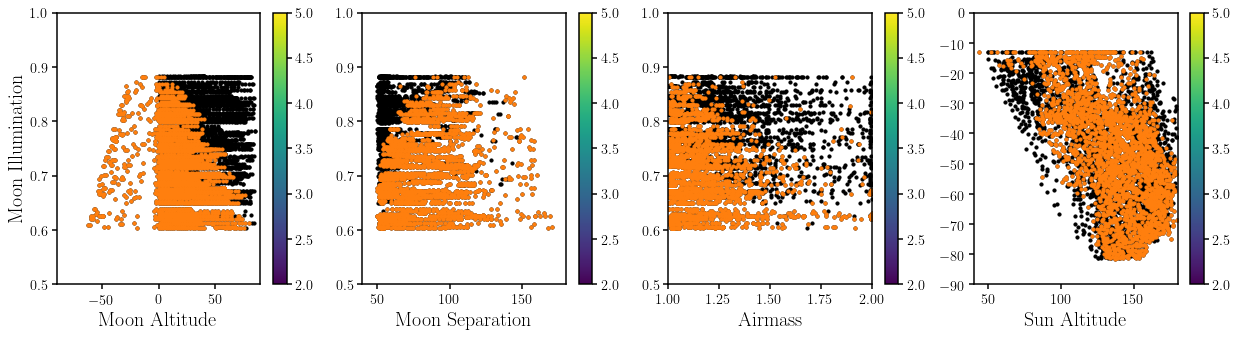

In [34]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['MOONALT'][notdark_ks], exps['MOONFRAC'][notdark_ks], c='C1', s=10)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(142)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['MOONSEP'][notdark_ks], exps['MOONFRAC'][notdark_ks], c='C1', s=10)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(143)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['AIRMASS'][notdark_ks], exps['MOONFRAC'][notdark_ks], c='C1', s=10)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(144)
sub.scatter(exps['SUNSEP'], exps['SUNALT'], c='k', s=10)
sub.scatter(exps['SUNSEP'][notdark_ks], exps['SUNALT'][notdark_ks], c='C1', s=10)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_xlabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

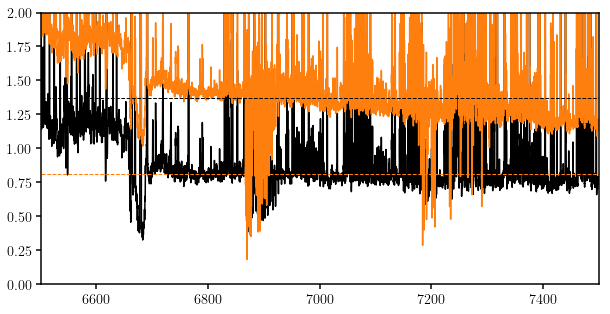

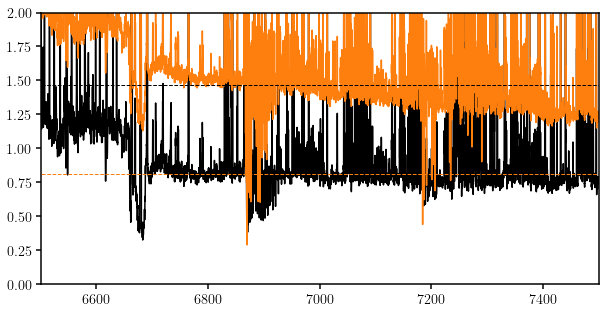

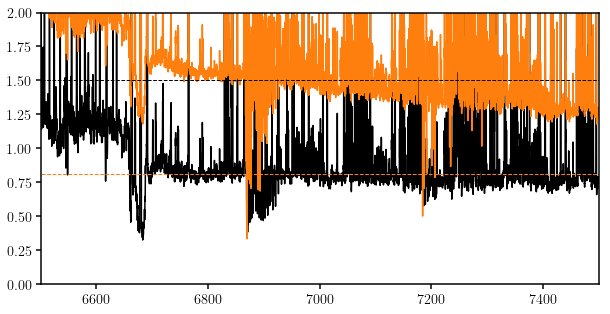

In [45]:
for i in range(3): 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(specsim_wave.value, dark_sbright, c='k')
    sub.plot([specsim_wave.value[0], specsim_wave.value[-1]], [dark_700, dark_700], c='C1', ls='--', lw=1)
    sub.plot(w_ks, exps_ks[np.arange(exps_ks.shape[0])[notdark_ks][i]], c='C1')
    sub.plot([specsim_wave.value[0], specsim_wave.value[-1]], 
             [exps_ks_700[np.arange(exps_ks.shape[0])[notdark_ks][i]], exps_ks_700[np.arange(exps_ks.shape[0])[notdark_ks][i]]], c='k', ls='--', lw=1)
    sub.set_xlim([6500., 7500.])
    sub.set_ylim([0., 2.])

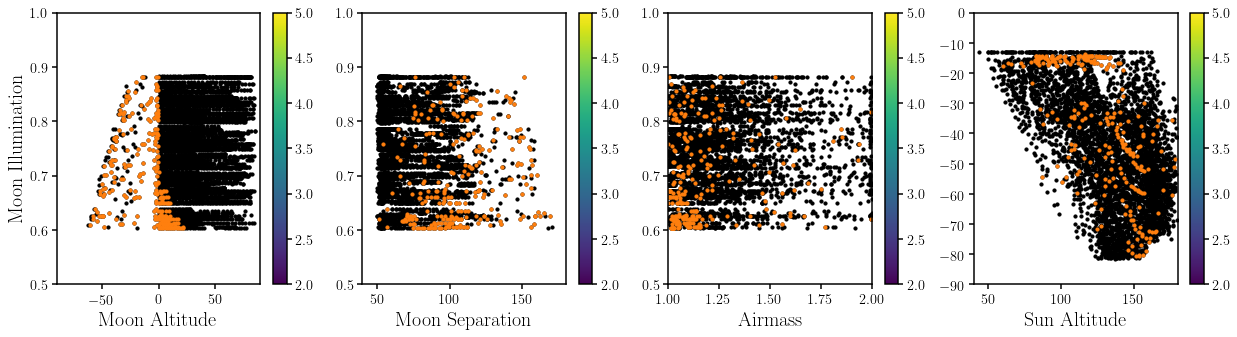

In [39]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['MOONALT'][notdark_new], exps['MOONFRAC'][notdark_new], c='C1', s=10)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(142)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['MOONSEP'][notdark_new], exps['MOONFRAC'][notdark_new], c='C1', s=10)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(143)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=10)
sub.scatter(exps['AIRMASS'][notdark_new], exps['MOONFRAC'][notdark_new], c='C1', s=10)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(144)
sub.scatter(exps['SUNSEP'], exps['SUNALT'], c='k', s=10)
sub.scatter(exps['SUNSEP'][notdark_new], exps['SUNALT'][notdark_new], c='C1', s=10)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_xlabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

In [46]:
ratio_410 = exps_new_410/exps_ks_410

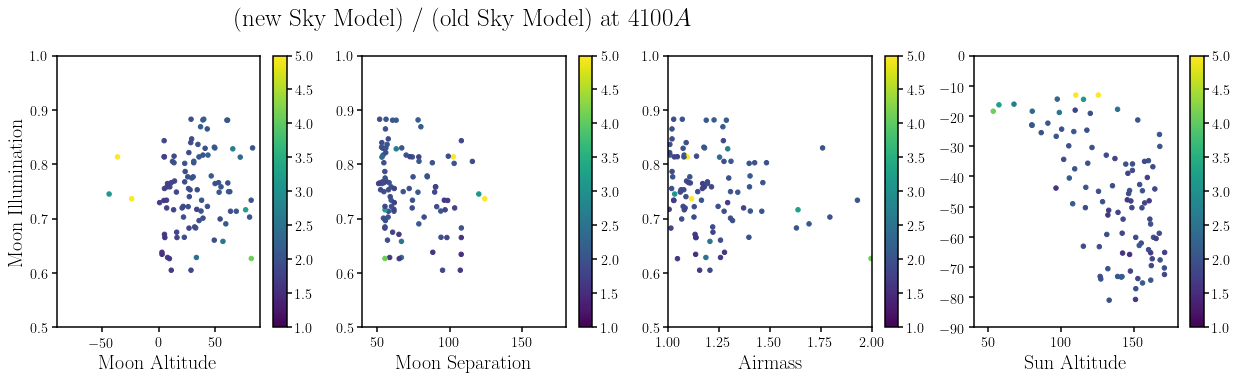

In [48]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
scat = sub.scatter(exps['MOONALT'][::50], exps['MOONFRAC'][::50], c=ratio_410[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(142)
scat = sub.scatter(exps['MOONSEP'][::50], exps['MOONFRAC'][::50], c=ratio_410[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4100A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(143)
scat = sub.scatter(exps['AIRMASS'][::50], exps['MOONFRAC'][::50], c=ratio_410[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(144)
scat = sub.scatter(exps['SUNSEP'][::50], exps['SUNALT'][::50], c=ratio_410[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_xlabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

In [49]:
wlim_460 = ((w_ks.value > 4400) & (w_ks.value < 4800))
exps_ks_460 = np.zeros(nexps)
exps_new_460 = np.zeros(nexps)
for i in range(nexps): 
    exps_ks_460[i] = np.median(medfilt(exps_ks[i,wlim_460], 51))
    exps_new_460[i] = np.median(medfilt(exps_new[i,wlim_460], 51))

In [50]:
ratio_460 = exps_new_460/exps_ks_460

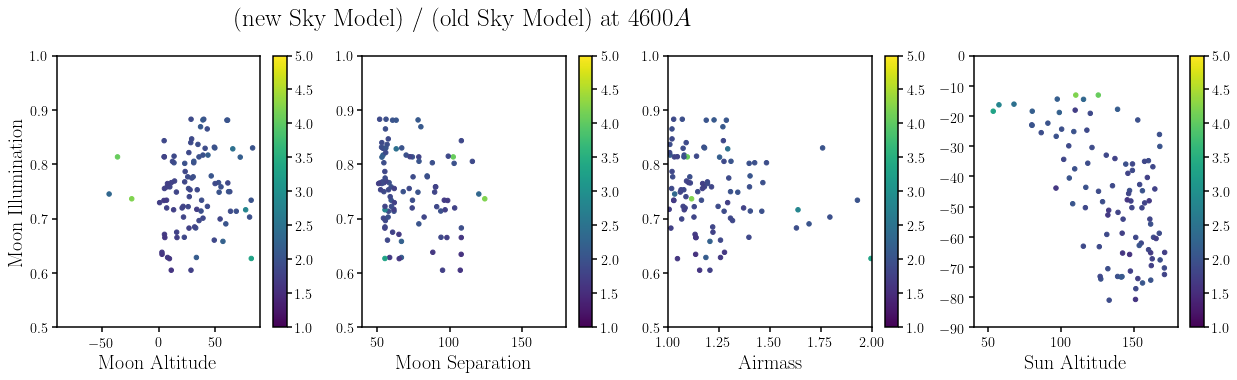

In [51]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
scat = sub.scatter(exps['MOONALT'][::50], exps['MOONFRAC'][::50], c=ratio_460[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(142)
scat = sub.scatter(exps['MOONSEP'][::50], exps['MOONFRAC'][::50], c=ratio_460[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
fig.colorbar(scat)

sub = fig.add_subplot(143)
scat = sub.scatter(exps['AIRMASS'][::50], exps['MOONFRAC'][::50], c=ratio_460[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
fig.colorbar(scat)

sub = fig.add_subplot(144)
scat = sub.scatter(exps['SUNSEP'][::50], exps['SUNALT'][::50], c=ratio_460[::50], s=20, vmin=1, vmax=5)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_xlabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
fig.colorbar(scat)

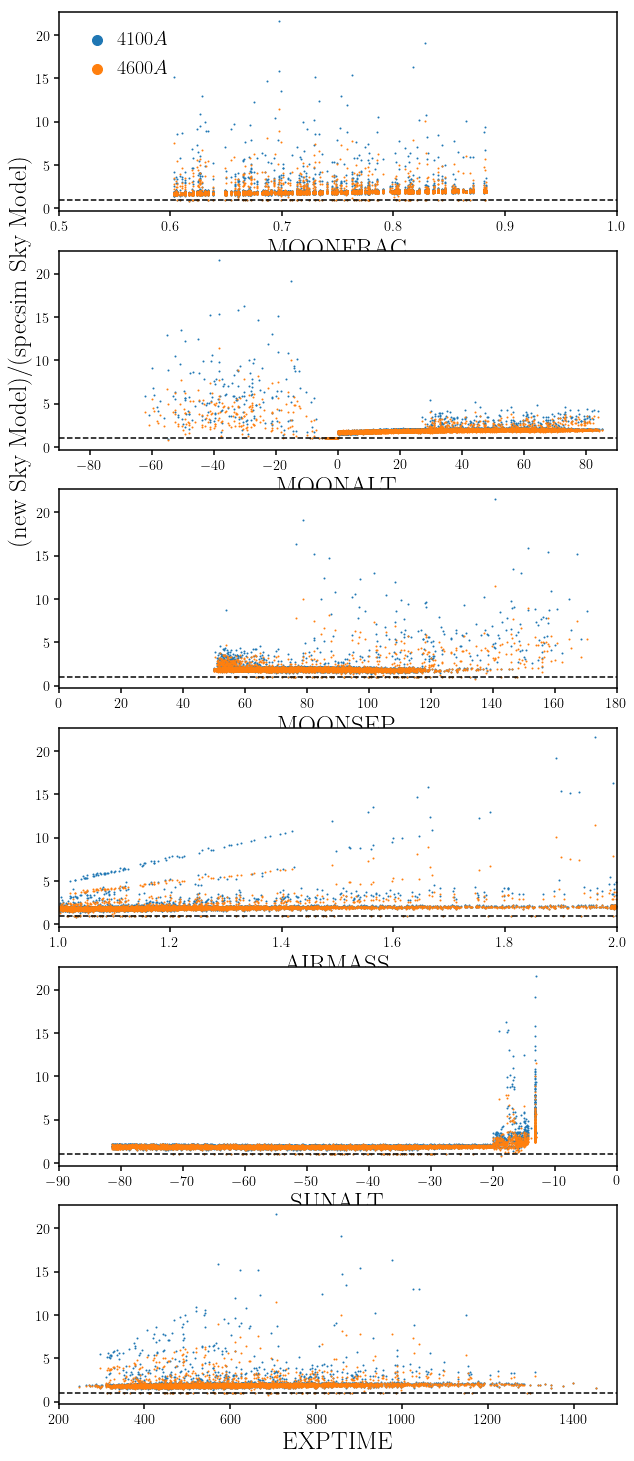

In [52]:
fig = plt.figure(figsize=(10, 30))
for i, k in enumerate(['MOONFRAC', 'MOONALT', 'MOONSEP', 'AIRMASS', 'SUNALT', 'EXPTIME']): 
    sub = fig.add_subplot(7,1,i+1)
    sub.scatter(exps[k], ratio_410, c='C0', s=1, label='$4100A$')
    sub.scatter(exps[k], ratio_460, c='C1', s=1, label='$4600A$')

    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper left', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.5, 1.])
    elif i == 1: 
        sub.set_xlim([-90., 90.])
        sub.set_ylabel('(new Sky Model)/(specsim Sky Model)', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    elif i == 4:
        sub.set_xlim([-90., 0.])
    elif i == 5:
        sub.set_xlim([200., 1500.])
    elif i == 6: 
        sub.set_xlim([0., 3.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')
    #sub.set_ylim([0., 5.])

In [31]:
for k in exps.keys(): 
    print k, exps[k][2268]

AVAILABLE 453
MJD 59749.1557003764
AIRMASS 1.961318855907878
STATUS 2
SNR2FRAC 0.8914369396699439
SEEING 0.9344444870948792
MOONFRAC 0.6974249452058101
SUNALT -13.08194360076192
MOONSEP 140.7723381279213
SUNSEP 43.75124698834343
PLANNED 745
TRANSPARENCY 0.9921120405197144
MOONALT -38.420427804856104
COVERED 401
PASS 6
DEC 49.29
EXPTIME 706.1383996073946
TILEID 36386
RA 132.63


Lets get a sample that spans the moon and sun meta-data space 

In [34]:
meta = np.zeros((nexps, 6))
meta[:,0] = exps['MOONFRAC']
meta[:,1] = exps['MOONALT']
meta[:,2] = exps['MOONSEP']
meta[:,3] = exps['AIRMASS']
meta[:,4] = exps['SUNALT']
meta[:,5] = exps['SUNSEP']

In [33]:
histmd, edges = np.histogramdd(meta, 2)
_hasexp = histmd > 0.
has_exp = np.where(_hasexp)
print('%i exposures' % np.sum(_hasexp))

50 exposures


In [78]:
iexp_sample = [] 
for i in range(np.sum(histmd > 0.)): 
    in_bin = np.ones(nexps).astype(bool)
    for i_dim in range(6): 
        in_bin = in_bin & (meta[:,i_dim] > edges[i_dim][has_exp[i_dim]][i]) & (meta[:,i_dim] <= edges[i_dim][has_exp[i_dim]+1][i])
    assert np.sum(in_bin) > 0
    iexp_sample.append(np.random.choice(np.arange(nexps)[in_bin], 1)[0])
iexp_sample = np.array(iexp_sample)

(-90.0, 0.0)

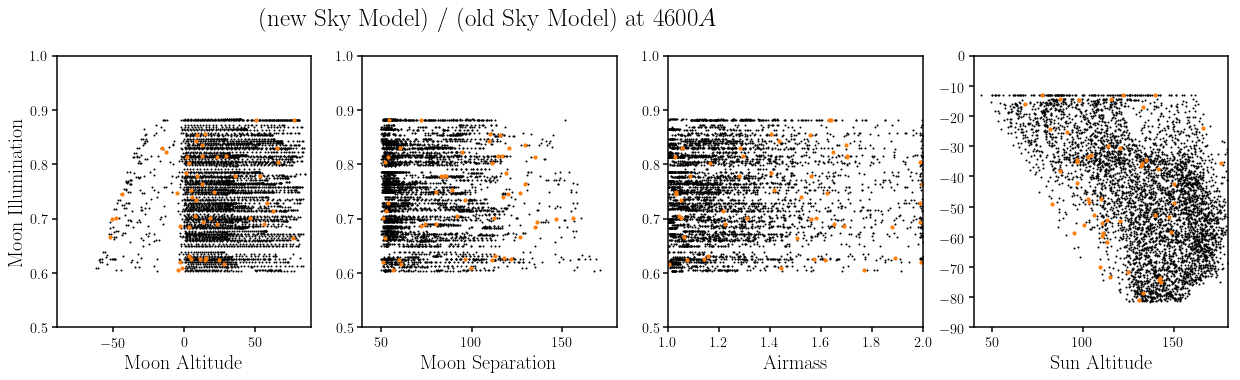

In [79]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['MOONALT'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10)#, vmin=1, vmax=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
#fig.colorbar(scat)

sub = fig.add_subplot(142)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['MOONSEP'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
#fig.colorbar(scat)

sub = fig.add_subplot(143)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['AIRMASS'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
#fig.colorbar(scat)

sub = fig.add_subplot(144)
sub.scatter(exps['SUNSEP'], exps['SUNALT'], c='k', s=1)
scat = sub.scatter(exps['SUNSEP'][iexp_sample], exps['SUNALT'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_xlabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
#fig.colorbar(scat)

In [84]:
f_iexp_metabin = ''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.iexp_metabin.dat']) 
np.savetxt(f_iexp_metabin, np.sort(iexp_sample), fmt='%i') 

Now lets get exposures that randomly sample the meta data (preserves the total distribution of meta-data)

In [35]:
iexp_sample = np.random.choice(np.arange(nexps), 50)
f_iexp_metabin = ''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.obscond_random.dat']) 
np.savetxt(f_iexp_metabin, np.sort(iexp_sample), fmt='%i') 

(-90.0, 0.0)

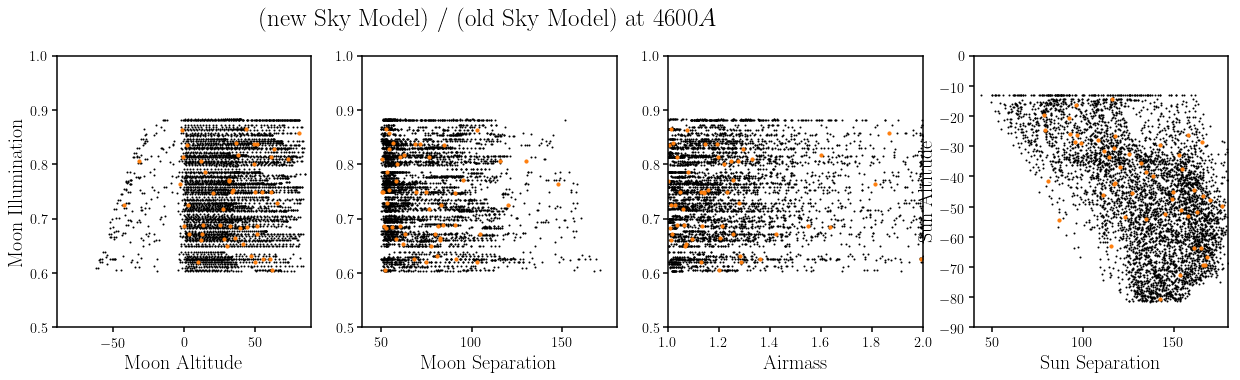

In [37]:
fig = plt.figure(figsize=(21,5))
sub = fig.add_subplot(141)
sub.scatter(exps['MOONALT'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['MOONALT'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10)#, vmin=1, vmax=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([-90., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0.5, 1.])
#fig.colorbar(scat)

sub = fig.add_subplot(142)
sub.scatter(exps['MOONSEP'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['MOONSEP'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])
sub.set_title('(new Sky Model) / (old Sky Model) at $4600A$', pad=30, fontsize=25)
#fig.colorbar(scat)

sub = fig.add_subplot(143)
sub.scatter(exps['AIRMASS'], exps['MOONFRAC'], c='k', s=1)
scat = sub.scatter(exps['AIRMASS'][iexp_sample], exps['MOONFRAC'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0.5, 1.])
#fig.colorbar(scat)

sub = fig.add_subplot(144)
sub.scatter(exps['SUNSEP'], exps['SUNALT'], c='k', s=1)
scat = sub.scatter(exps['SUNSEP'][iexp_sample], exps['SUNALT'][iexp_sample], c='C1', s=10) #ratio_460[::50], s=10, vmin=1, vmax=5)
sub.set_xlabel('Sun Separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylabel('Sun Altitude', fontsize=20)
sub.set_ylim([-90., 0.])
#fig.colorbar(scat)